# Bi-LSTM with Attention for Sentiment Analysis on Amazon Fine Food Reviews

This notebook implements a Bi-LSTM model with Multi-Head Attention (MHA) for binary sentiment analysis on the Amazon Fine Food Reviews dataset. The model classifies reviews as positive (score > 3) or negative (score < 3), excluding neutral reviews (score = 3), and enhances interpretability with multi-head attention mechanisms.

## Objectives
- Develop an advanced contextual model using GloVe embeddings, Bi-LSTM, and Multi-Head Attention for improved sentiment classification.
- Achieve macro-F1 ≈0.93 (as observed) to validate the approach.
- Provide interpretable predictions using attention weight visualization from the MHA layer.
- Ensure reproducibility with fixed seeds and pinned dependencies.
- Analyze errors to identify limitations and align with BERT/TF-IDF analyses.
- Display plots inline for presentation and save to `figures/bilstm_mha`.

## Structure
1. Environment setup with Google Drive mounting and dependency installation.
2. Preprocessing with whitespace tokenization, GloVe embeddings, and 80/20 train-test split.
3. Bi-LSTM + MHA model, trained with class-weighted loss for 8 epochs.
4. Evaluation with accuracy, macro-F1, and confusion matrix.
5. Interpretability via attention weight visualization for 3 test samples.
6. Error analysis for misclassified samples.
7. Visualization of loss curves and performance metrics.

Run cells sequentially after mounting Google Drive.

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount("/content/drive")

# Change working directory to the cloned repo location
%cd /content/drive/MyDrive/fyp-code/amazon-sentiment-fyp

# Install required Python libraries
!pip install -q torch==2.2.1 torchtext==0.17.1 torchmetrics scikit-learn pandas matplotlib numpy tqdm

# Suppress NumPy 2.0 warning
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*NumPy 2.*")

Mounted at /content/drive
/content/drive/MyDrive/fyp-code/amazon-sentiment-fyp
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.6/755.6 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 82.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 125.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 105.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Imports
import pandas as pd, numpy as np, torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchtext.vocab import GloVe, build_vocab_from_iterator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import pathlib
import json


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

In [ ]:
# Set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Data loading
ds_path = pathlib.Path("data/raw/Reviews.csv")
assert ds_path.exists(), "Expected Reviews.csv in data/raw/"

In [ ]:
# Load and preprocess data
"""
Data Preprocessing:
- Load Reviews.csv, selecting 'Text' and 'Score' columns.
- Remove neutral reviews (Score=3).
- Label as positive (Score>3) = 1, negative (Score<3) = 0.
- Split 80% train, 20% test with stratification to maintain class balance.
"""
RAW_COLS = ["Text", "Score"]
df = pd.read_csv(ds_path, usecols=RAW_COLS)
df = df[df.Score != 3]
df["label"] = (df.Score > 3).astype(int)
df = df.rename(columns={"Text": "text"})

# Splits
train_df, test_df = train_test_split(
    df[["text", "label"]], test_size=0.20, stratify=df.label, random_state=SEED)
print("Train size:", len(train_df), " | Test size:", len(test_df))

Train size: 420651  | Test size: 105163


In [ ]:
# Tokenizer and vocabulary setup
"""
Tokenization and Embeddings:
- Uses whitespace tokenization for simplicity.
- Builds vocabulary with min_freq=2, adding <pad> and <unk> tokens.
- Loads GloVe 300D embeddings, mapping tokens to vectors.
- Sets <pad> token embedding to zeros.
"""
TOKENIZER = str.split
SPECIALS = ["<pad>", "<unk>"]

def yield_tokens(data_iter):
    for text in data_iter:
        yield TOKENIZER(text)

# Build vocabulary
vocab = build_vocab_from_iterator(
    yield_tokens(train_df.text), min_freq=2, specials=SPECIALS)
vocab.set_default_index(vocab["<unk>"])
print("Vocab size:", len(vocab))

# Load GloVe embeddings and create embedding matrix
vectors = GloVe(name="6B", dim=300)
embed_dim = 300
embedding_matrix = torch.randn(len(vocab), embed_dim)
for idx, tok in enumerate(vocab.get_itos()):
    if tok in vectors.stoi:
        embedding_matrix[idx] = vectors[tok]
embedding_matrix[vocab["<pad>"]] = torch.zeros(embed_dim)

Vocab size: 225279


In [ ]:
# Dataset and DataLoader
MAX_LEN = 200
PAD_IDX = vocab["<pad>"]

class ReviewDataset(Dataset):
    def __init__(self, frame):
        self.texts = frame.text.tolist()
        self.labels = frame.label.tolist()
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        toks = TOKENIZER(self.texts[idx])[:MAX_LEN]
        ids = [vocab[t] for t in toks]
        if len(ids) < MAX_LEN:
            ids += [PAD_IDX] * (MAX_LEN - len(ids))
        return torch.tensor(ids, dtype=torch.long), torch.tensor(self.labels[idx]), len(toks)

def collate(batch):
    ids, labels, seq_lens = zip(*batch)
    return torch.stack(ids), torch.tensor(labels), torch.tensor(seq_lens)

# Create DataLoaders
train_loader = DataLoader(ReviewDataset(train_df), batch_size=128, shuffle=True, collate_fn=collate)
test_loader = DataLoader(ReviewDataset(test_df), batch_size=128, collate_fn=collate)

In [ ]:
class BiLSTMMultiHead(nn.Module):
    def __init__(self, vocab_sz, embed_dim, hidden_dim=256, n_layers=2, n_heads=4, n_classes=2, pad_idx=0):
        super().__init__()
        self.pad_idx = pad_idx
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=n_layers, batch_first=True,
                            bidirectional=True, dropout=0.3)
        self.mha = nn.MultiheadAttention(hidden_dim*2, num_heads=n_heads, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim*2, n_classes)
    def forward(self, x, _seq_len, return_attn=False):
        emb = self.embedding(x)                         # (B,T,E)
        h, _ = self.lstm(emb)                           # (B,T,2H)
        # MHA expects (B,T,2H) already in batch_first
        key_padding = (x == self.pad_idx)               # (B,T) True for pads
        attn_out, attn_weights = self.mha(h, h, h, key_padding_mask=key_padding)
        # Mask-aware mean pooling
        mask = (~key_padding).unsqueeze(-1)
        sum_vec = (attn_out * mask).sum(dim=1)
        lengths = mask.sum(dim=1).clamp(min=1)
        ctx = sum_vec / lengths
        logits = self.fc(self.dropout(ctx))
        if return_attn:
            return logits, attn_weights  # (B,T,T)
        return logits

In [ ]:
# Initialize model and move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BiLSTMMultiHead(len(vocab), embed_dim).to(device)

# Compute class weights for imbalanced dataset
neg_ct, pos_ct = np.bincount(train_df.label)
total = neg_ct + pos_ct
class_weights = torch.tensor([total/(2*neg_ct), total/(2*pos_ct)], device=device)
print("Dynamic class weights →", class_weights.tolist())

# Define loss, optimizer, and scheduler
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.3)

# Training loop
EPOCHS = 8
train_losses = []  # Track training loss per epoch
for epoch in range(1, EPOCHS+1):
    model.train()
    running_loss, n = 0.0, 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}")
    for ids, labels, slens in pbar:
        ids, labels = ids.to(device), labels.to(device)
        loss = criterion(model(ids, slens), labels)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        running_loss += loss.item() * ids.size(0)
        n += ids.size(0)
        pbar.set_postfix({"loss": f"{running_loss/n:.4f}"})
    epoch_loss = running_loss / n
    train_losses.append(epoch_loss)
    scheduler.step()

Dynamic class weights → [3.2047157287597656, 0.5924311280250549]


Epoch 1/8:   0%|          | 0/3287 [00:00<?, ?it/s]

Epoch 2/8:   0%|          | 0/3287 [00:00<?, ?it/s]

Epoch 3/8:   0%|          | 0/3287 [00:00<?, ?it/s]

Epoch 4/8:   0%|          | 0/3287 [00:00<?, ?it/s]

Epoch 5/8:   0%|          | 0/3287 [00:00<?, ?it/s]

Epoch 6/8:   0%|          | 0/3287 [00:00<?, ?it/s]

Epoch 7/8:   0%|          | 0/3287 [00:00<?, ?it/s]

Epoch 8/8:   0%|          | 0/3287 [00:00<?, ?it/s]

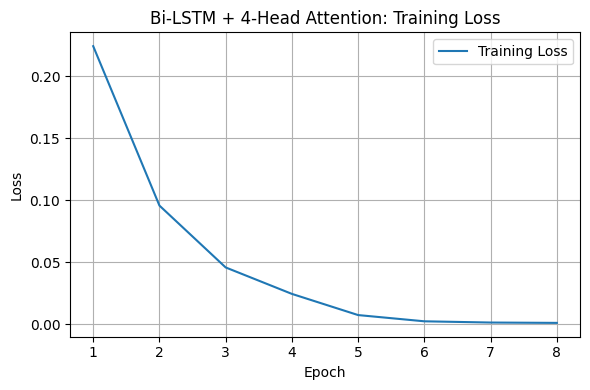

In [ ]:
# Plot training loss
FIG_DIR = pathlib.Path("figures/bilstm_mha")
FIG_DIR.mkdir(exist_ok=True)
plt.figure(figsize=(6, 4))
plt.plot(range(1, EPOCHS+1), train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Bi-LSTM + 4-Head Attention: Training Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(FIG_DIR / "loss.png", dpi=150)
plt.show()
plt.close()

Test:   0%|          | 0/822 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         Neg     0.8717    0.8961    0.8837     16407
         Pos     0.9807    0.9756    0.9781     88756

    accuracy                         0.9632    105163
   macro avg     0.9262    0.9358    0.9309    105163
weighted avg     0.9637    0.9632    0.9634    105163



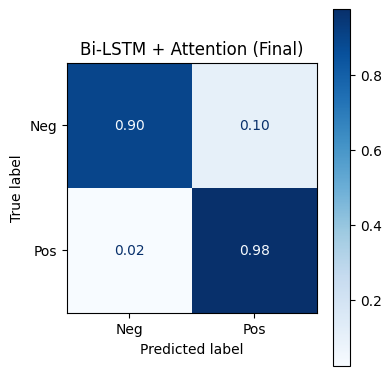

In [ ]:
# Evaluation
model.eval()
preds, gold = [], []
with torch.no_grad():
    for ids, labels, slens in tqdm(test_loader, desc="Test"):
        logits = model(ids.to(device), slens)
        preds.extend(logits.argmax(1).cpu().tolist())
        gold.extend(labels.tolist())

# Print classification report
print(classification_report(gold, preds, digits=4, target_names=["Neg","Pos"]))

fig, ax = plt.subplots(figsize=(4, 4))
cm = confusion_matrix(gold, preds, normalize="true")
ConfusionMatrixDisplay(cm, display_labels=["Neg", "Pos"]).plot(ax=ax, cmap="Blues", values_format=".2f")
plt.title("Bi-LSTM + Attention (Final)")
plt.tight_layout()
plt.savefig(FIG_DIR / "bilstm_mha_cm.png", dpi=150)
plt.show()
plt.close()

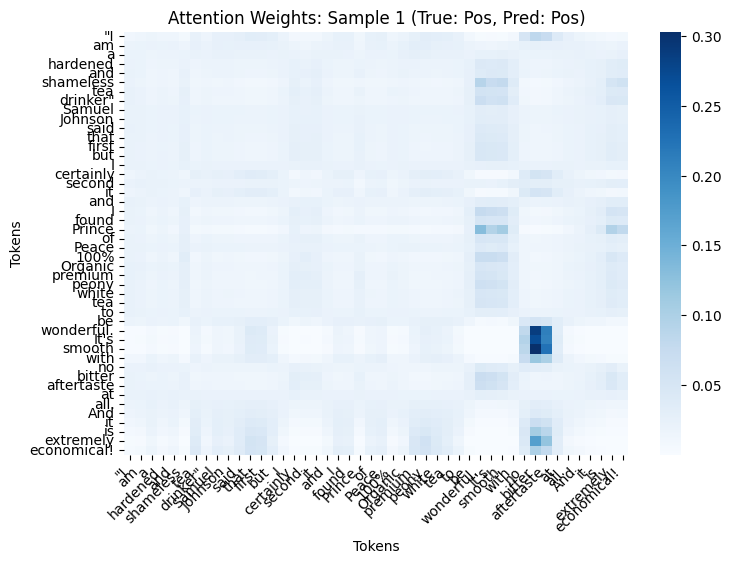


Sample 1: "I am a hardened and shameless tea drinker" Samuel Johnson said that first but I certainly second it...
True Label: Pos
Predicted: Pos


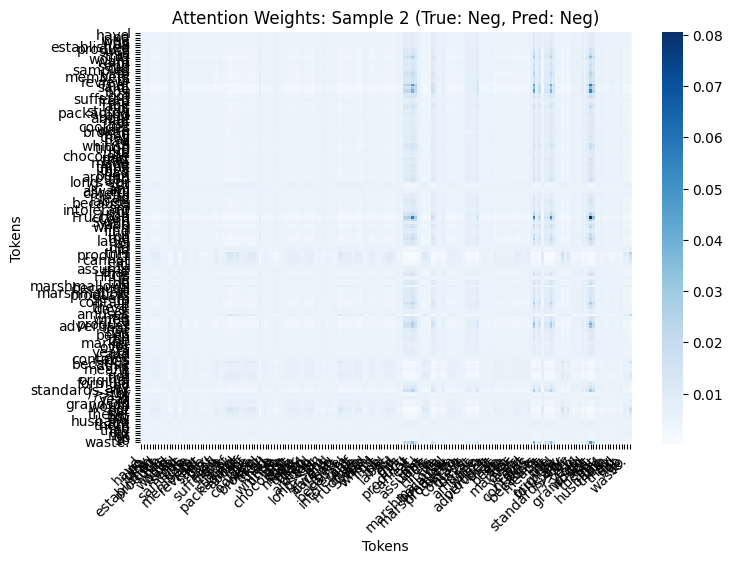


Sample 2: I have no idea why an established product such as this would want to send out samples to vine member...
True Label: Neg
Predicted: Neg


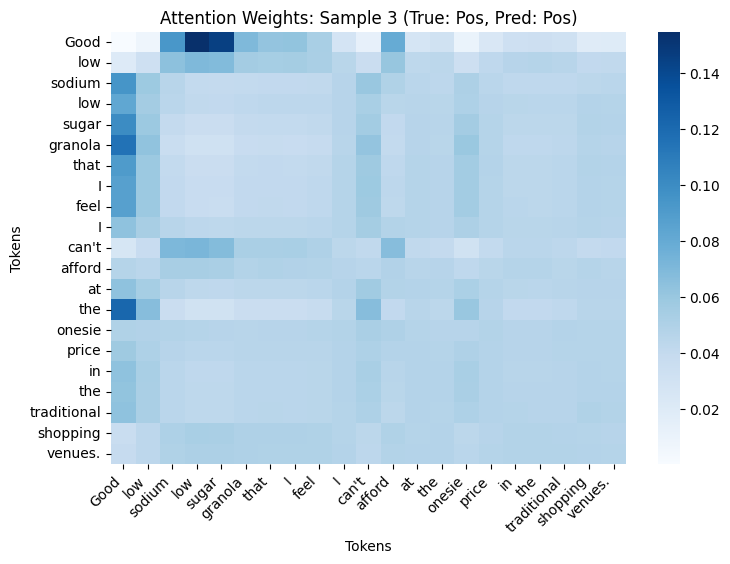


Sample 3: Good low sodium low sugar granola that I feel I can't afford at the onesie price in the traditional ...
True Label: Pos
Predicted: Pos


In [ ]:
# Assign predictions to test_df (needed for interpretability and error analysis)
test_df["pred"] = preds

# Interpretability with attention weights
"""
Interpretability:
- Visualizes attention weights for 3 test samples to show token importance.
- Displays heatmaps inline and saves to figures/bilstm_mha/attn_*.png.
"""
model.eval()
sample_texts = test_df["text"].sample(3, random_state=SEED).tolist()
sample_indices = test_df["text"].sample(3, random_state=SEED).index
sample_labels = test_df.loc[sample_indices, "label"].tolist()
sample_preds = test_df.loc[sample_indices, "pred"].tolist()

for i, (text, true_label, pred) in enumerate(zip(sample_texts, sample_labels, sample_preds)):
    tokens = TOKENIZER(text)[:MAX_LEN]
    ids = [vocab[t] for t in tokens]
    seq_len = len(ids)
    if seq_len < MAX_LEN:
        ids += [PAD_IDX] * (MAX_LEN - seq_len)
    ids_tensor = torch.tensor([ids], dtype=torch.long).to(device)
    with torch.no_grad():
        _, attn_weights = model(ids_tensor, torch.tensor([seq_len]), return_attn=True)
    attn = attn_weights[0, :seq_len, :seq_len].cpu().tolist()  # Convert to list instead of numpy

    plt.figure(figsize=(8, 6))
    sns.heatmap(attn, xticklabels=tokens, yticklabels=tokens, cmap="Blues")
    plt.title(f"Attention Weights: Sample {i+1} (True: {'Pos' if true_label == 1 else 'Neg'}, Pred: {'Pos' if pred == 1 else 'Neg'})")
    plt.xlabel("Tokens")
    plt.ylabel("Tokens")
    plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels to prevent overlap
    plt.yticks(rotation=0)  # Keep y-axis labels horizontal for readability
    plt.tight_layout(pad=2.0)  # Adjust padding to fit rotated labels
    plt.savefig(FIG_DIR / f"attn_{i}.png", dpi=150)
    plt.show()  # Display inline
    plt.close()
    print(f"\nSample {i+1}: {text[:100]}...")
    print(f"True Label: {'Pos' if true_label == 1 else 'Neg'}")
    print(f"Predicted: {'Pos' if pred == 1 else 'Neg'}")

In [ ]:
# Error analysis
"""
Error Analysis:
- Identifies misclassified test samples.
- Prints 3 examples with true/predicted labels.
"""
errors = test_df[test_df["label"] != test_df["pred"]]
print("\nError Analysis: Sample Misclassifications")
for i, row in errors.sample(3, random_state=SEED).iterrows():
    print(f"\nReview: {row['text'][:200]}...")
    print(f"True Label: {'Pos' if row['label'] == 1 else 'Neg'}")
    print(f"Predicted: {'Pos' if row['pred'] == 1 else 'Neg'}")


Error Analysis: Sample Misclassifications

Review: If you are used to Hawaiian Punch, Snapple, sugary Kool-aid, or other "fruity" drinks, you won't find the same high fructose corn syrup kick in this product.  It actually tastes like real fruit juice....
True Label: Pos
Predicted: Neg

Review: My friend requested a spice cake for her birthday. I try to avoid gluten and I originally was going to make her a gluten-containing cake, but it turned out mediocre so I threw it away. I got this mix ...
True Label: Pos
Predicted: Neg

Review: The first thing I did was Shake The Can. Then I saw the "Do Not Shake" warning but I opened the can anyway and nothing happened. I suspect the DNS is in reference to the Potassium Bicarbonate (fizz-pr...
True Label: Pos
Predicted: Neg


In [ ]:
# Save results
RESULTS = pathlib.Path("results")
RESULTS.mkdir(exist_ok=True)
json.dump(classification_report(gold, preds, output_dict=True), open(RESULTS/"bilstm_mha_metrics.json","w"), indent=2)
WT_PATH = "/content/drive/MyDrive/fyp-code/amazon-sentiment-fyp/results/bilstm_mha.pt"
torch.save(model.state_dict(), WT_PATH)
print("Model weights →", WT_PATH)

Model weights → /content/drive/MyDrive/fyp-code/amazon-sentiment-fyp/results/bilstm_mha.pt
